### Import, mount, and configure.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

DRIVE_ROOT = Path('/content/drive/MyDrive')
PROJECT_ROOT = DRIVE_ROOT / 'projects/bitcoin'

Mounted at /content/drive


In [2]:
# Include the project root in the system path to enable custom module imports.
project_root = os.path.abspath(PROJECT_ROOT)
if project_root not in sys.path:
  sys.path.append(project_root)

In [3]:
# Import custom functions from custom modules.
from src.data_loader import load_cleaned_dataset, resample_and_aggregate_dataset
from src.data_splitter import split_dataset

### Load the cleaned dataset, then perform resampling and aggregation.

In [4]:
bitcoin_cleaned = load_cleaned_dataset()

In [5]:
bitcoin_ohlcv = resample_and_aggregate_dataset(bitcoin_cleaned)

In [6]:
bitcoin_daily = bitcoin_ohlcv['daily']

### Split the dataset into a training, validation and a test set.

In [7]:
train_set, valid_set, test_set = split_dataset(bitcoin_daily)

In [8]:
print(f'Training data size: {len(train_set)}')
print(f'Validation data size: {len(valid_set)}')
print(f'Test data size: {len(test_set)}')

Training data size: 3936
Validation data size: 492
Test data size: 493


### Perform naive forecasting.

#### Monthly prediction.

In [9]:
diff_30_train = train_set.diff(30)

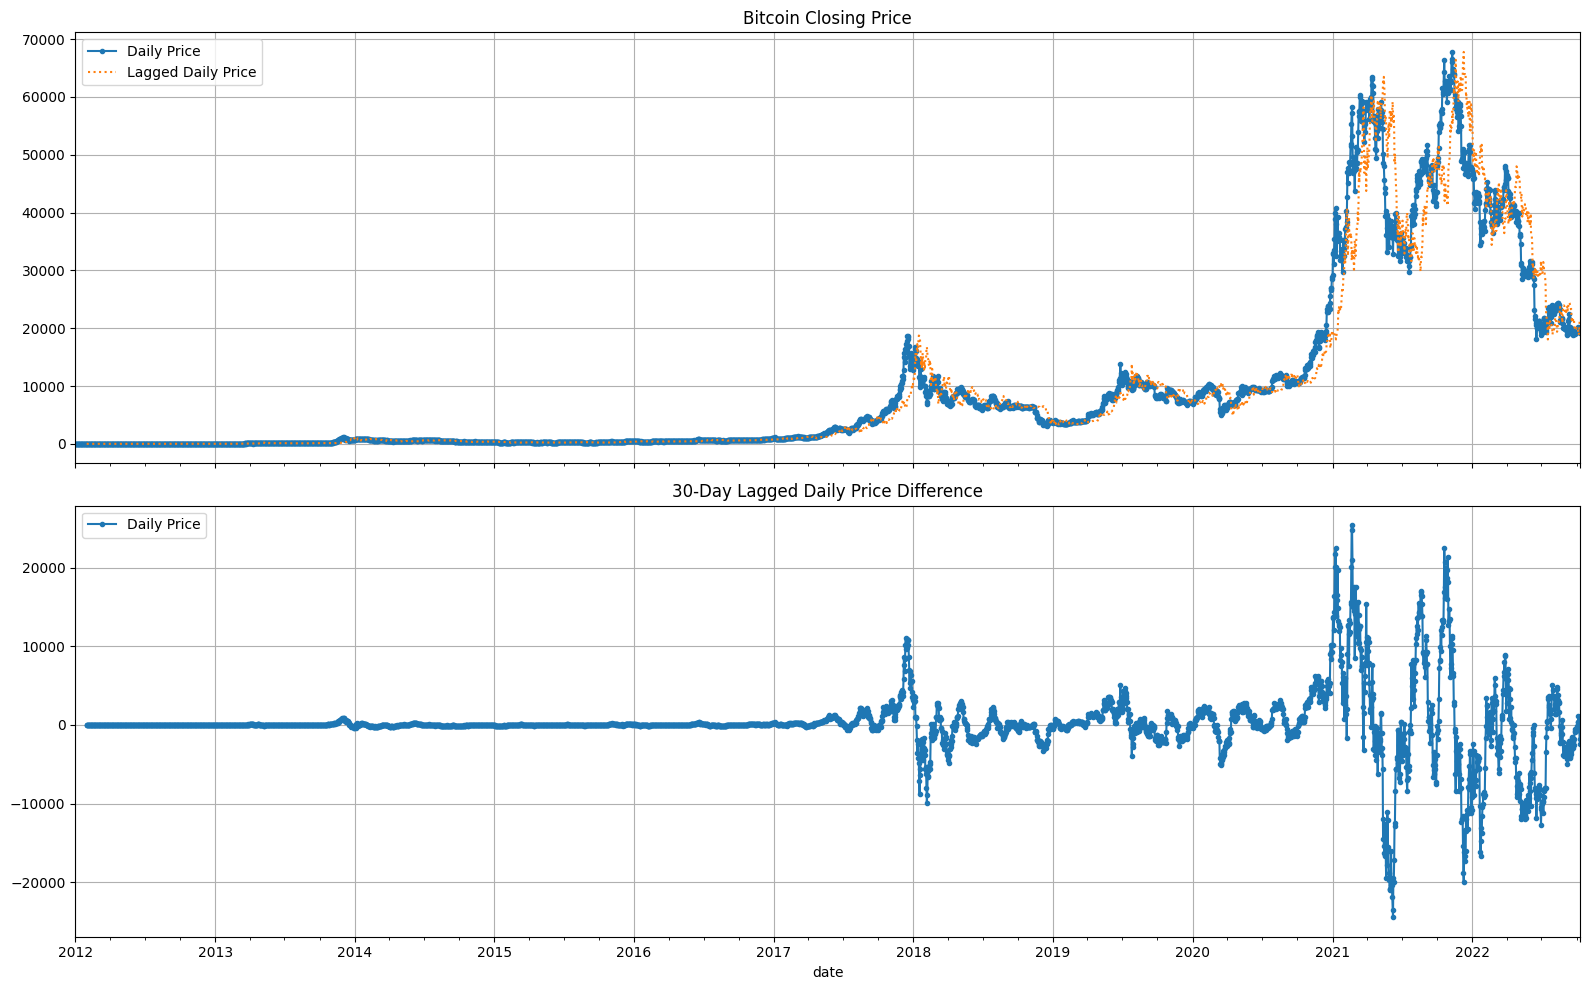

In [10]:
# Resampling and aggregating essentially smoothes out high-frequency noises, leaving the dominant long-term trends.
# Therefore, multiple time granularities for graphs and MAPE scores are basically redundant.
# The daily dataset is the most common and highly recommended as a baseline.
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(16, 10),
    sharex=True,
)

train_set['close'].plot(ax=ax1, legend=True, label='Daily Price', marker='.')
train_set['close'].shift(30).plot(ax=ax1, grid=True, legend=True, label='Lagged Daily Price', linestyle=':')
ax1.set_title('Bitcoin Closing Price')
ax1.legend(loc='upper left')

diff_30_train['close'].plot(ax=ax2, grid=True,legend=True, label='Daily Price', marker='.')
ax2.set_title('30-Day Lagged Daily Price Difference')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
diff_30_test = test_set.diff(30)

In [12]:
mape_month = (diff_30_test / test_set.shift(30))['close'].abs().mean()
print(f'Naive Forecast MAPE on Test Set (Monthly): {100 * mape_month:.4f}%')

Naive Forecast MAPE on Test Set (Monthly): 10.8799%


#### Yearly prediction.

In [13]:
diff_365_train = train_set.diff(365)

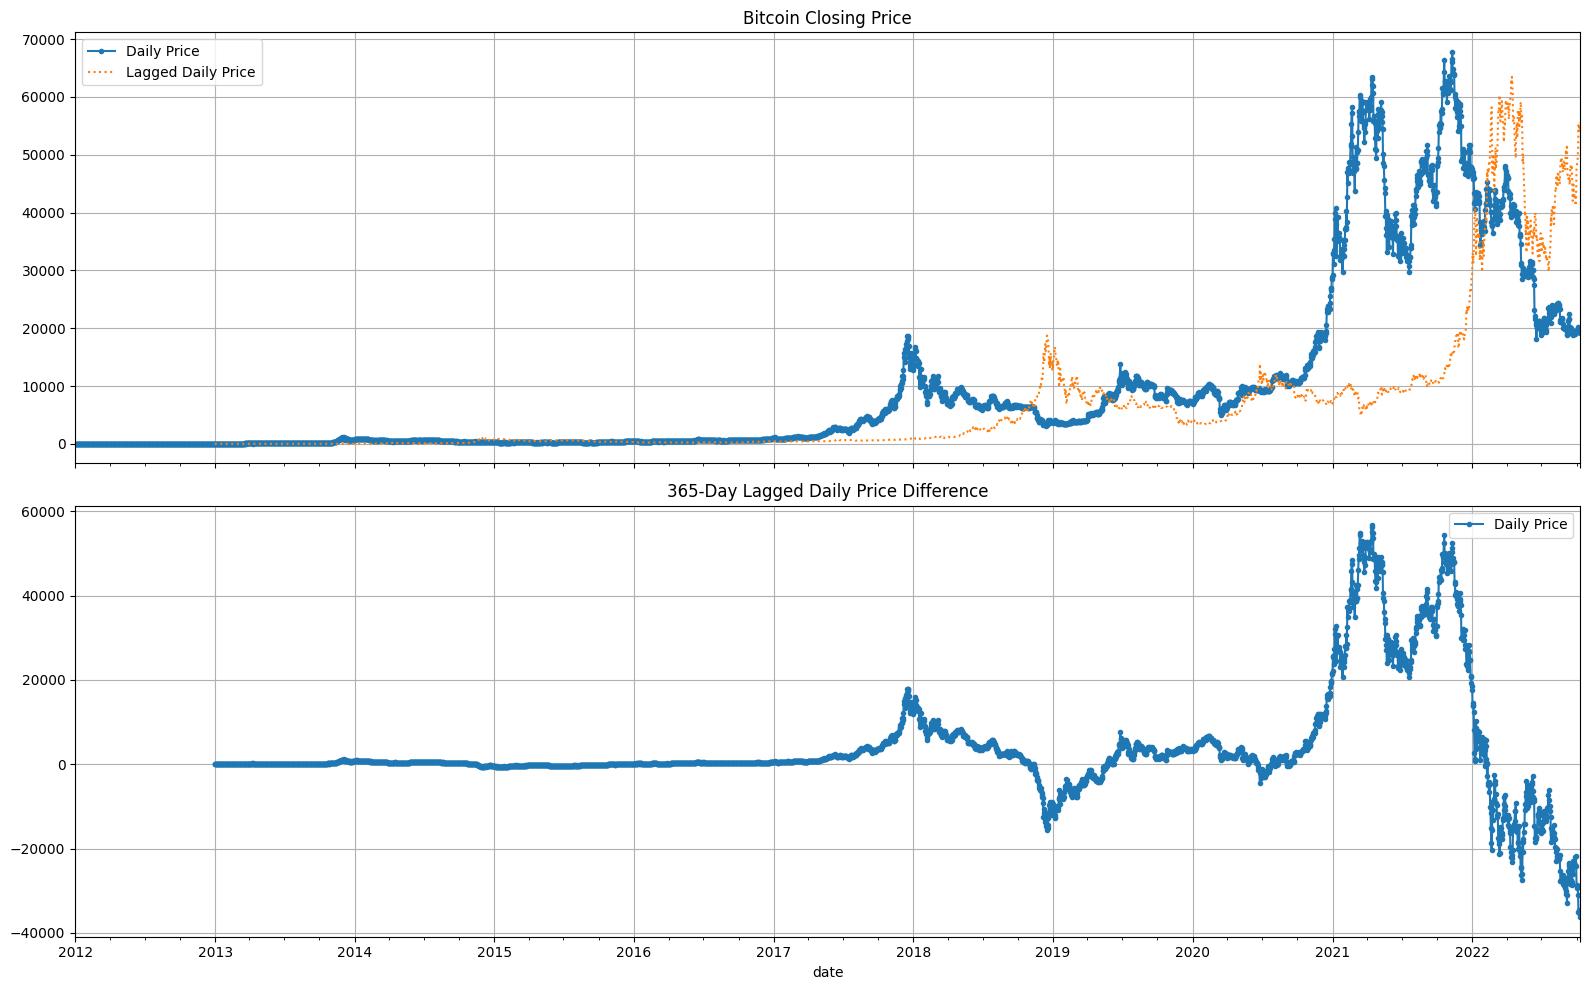

In [14]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(16, 10),
    sharex=True,
)

train_set['close'].plot(ax=ax1, legend=True, label='Daily Price', marker='.')
train_set['close'].shift(365).plot(ax=ax1, grid=True, legend=True, label='Lagged Daily Price', linestyle=':')
ax1.set_title('Bitcoin Closing Price')

diff_365_train['close'].plot(ax=ax2, grid=True, legend=True, label='Daily Price', marker='.')
ax2.set_title('365-Day Lagged Daily Price Difference')

plt.tight_layout()
plt.show()

In [15]:
diff_365_test = test_set.diff(365)

In [16]:
mape_year = (diff_365_test / test_set.shift(365))['close'].abs().mean() # test_set['close'].pct_change(periods=365).abs().mean()
print(f'Naive Forecast MAPE on Test Set (Yearly): {100 * mape_year:.4f}%')

Naive Forecast MAPE on Test Set (Yearly): 46.5728%


#### Directional Accuracy.

In [17]:
# Assumption: The direction over the next X days will be the same as the direction over the previous X days.
def calculate_long_horizon_da(dataset, horizon_days):
  # Calculate the actual direction of price movement over the horizon.
  actual_direction = np.sign(dataset['close'].diff(horizon_days))
  # Create the naive predictions by lagging the actual direction.
  # The lag must match the horizion period.
  predicted_direction = actual_direction.shift(horizon_days)
  # Compare the actuals and predictions.
  # > 0 if the signs are the same(both up and down).
  correct_preds = (actual_direction * predicted_direction > 0).sum()
  # Calculate the accuracy.
  total_preds = predicted_direction.notna().sum()

  if total_preds == 0:
    return 0.0

  directional_accuracy = correct_preds / total_preds

  return directional_accuracy

In [18]:
da_monthly = calculate_long_horizon_da(test_set, 30)
print(f"Naive Directional Accuracy on Test Set (Monthly): {da_monthly*100:.2f}%")

da_yearly = calculate_long_horizon_da(test_set, 365)
print(f"Naive Directional Accuracy on Test Set (Yearly): {da_yearly*100:.2f}%")

Naive Directional Accuracy on Test Set (Monthly): 42.03%
Naive Directional Accuracy on Test Set (Yearly): 0.00%


In [19]:
actual_dir = np.sign(test_set['close'].diff())
predicted_dir = actual_dir.shift(1)
correct_preds = (actual_dir * predicted_dir > 0).sum()

In [20]:
total_preds = predicted_dir.notna().sum()
directional_accuracy = correct_preds / total_preds

In [21]:
print(f'Naive 1-Day Directional Accuracy on Test Set: {directional_accuracy:.4f} ({directional_accuracy*100:.2f}%)')

Naive 1-Day Directional Accuracy on Test Set: 0.4684 (46.84%)
